In [1]:
import pandas as pd
import sklearn
import numpy as np
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import scipy 
import arcgis

In [2]:
from arcgis.gis import GIS
from arcgis.features import GeoAccessor,GeoSeriesAccessor
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import cross_val_predict, KFold
from sklearn.neighbors import NearestNeighbors, KNeighborsClassifier, KNeighborsRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from statsmodels.formula.api import ols

In [3]:
%matplotlib inline
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from math import sqrt
from scipy import stats

In [4]:
# read data
gis = GIS()

kc_columns = ['price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 'waterfront', 'view', 
              'condition', 'grade', 'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long', 'sqft_living15',
              'sqft_lot15']

kc_dtypes = {'id': int, 'date' : str,  'price': float, 'bedrooms' : int, 'bathrooms' : float, 'sqft_living': int, 'sqft_lot': int, 'floors': float, 
             'waterfront': float, 'view' : float, 'condition': float, 'grade': int, 'sqft_above': int, 'yr_built': int,
             'yr_renovated': float, 'zipcode': float, 'lat': float, 'long': float, 'sqft_living15': int, 'sqft_lot15': int}

kc_data = pd.read_csv('dsc-phase-2-project/data/Cleaned_Dataset.csv', parse_dates = ['date'])

In [5]:
#fitting our model by dropping features that dont do much & transforming others into 
#useful data points through multiplying them 
#removing homes with horrible bed to bath ratios 
kc_data['ratio_bd_bth'] = kc_data['bedrooms']/kc_data['bathrooms']
kc_data['sqft_abv_and_living'] = kc_data['sqft_above']*kc_data['sqft_living']
kc_data['sqft_15'] = kc_data['sqft_living15']*kc_data['sqft_lot15']
 


kc_data = kc_data.loc[kc_data['ratio_bd_bth'] < 4]
kc_data = kc_data.loc[kc_data['floors'] <= 3]
kc_data = kc_data.drop('date', axis=1)#.drop('sqft_above', axis=1).drop('id', axis=1)
#kc_data = kc_data.drop('sqft_living', axis=1).drop('sqft_basement', axis=1)

kc_columns.append(['ratio_bd_bth', 'sqft_abv_and_living', 'sqft_15'])

In [6]:
#filtering by zscore where applicable 
#not applicable: zipcode, yr built(wouldn't want to exclude all recent homes)
# year renovated, basement sqft, view & waterfront (usually 0), floors (only 4, certainly already outlier free)

kc_columns = ['price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 
              'condition', 'grade', 'sqft_above', 'sqft_living15', 'sqft_lot15']
zscore_columns = []

for col in kc_columns:
    col_zscore = str(col + '_zscore')
    kc_data[col_zscore] = (kc_data[col] - kc_data[col].mean())/kc_data[col].std(ddof=0)
    zscore_columns.append(col_zscore)

for column in zscore_columns:
    kc_data = kc_data.loc[kc_data[column] < 3]
    kc_data = kc_data.loc[kc_data[column] > (-3)]

In [7]:
kcx = kc_data[['price']]
kcy = kc_data.drop('price', axis=1)

In [8]:
# initialize regression
reg = linear_model.LinearRegression()
# split data into 80/20 training/testing
x_train, x_test, y_train, y_test = train_test_split(kcx, kcy, test_size=0.2, random_state=42)
# train the model 
reg.fit(x_train, y_train)
# print test data predictions 
y_pred = reg.predict(x_test)

In [9]:
# check accuracy with mean sq 
print(np.mean((y_pred - y_test)**2))

id                      1.436797e+18
bedrooms                5.915750e-01
bathrooms               3.583221e-01
sqft_living             3.193317e+05
sqft_lot                1.311629e+08
floors                  2.690440e-01
waterfront              2.361069e-03
view                    3.423548e-01
condition               4.108521e-01
grade                   5.825996e-01
sqft_above              3.341208e+05
sqft_basement           1.442180e+05
yr_built                8.217873e+02
yr_renovated            1.300674e+05
zipcode                 2.811979e+03
lat                     1.587460e-02
long                    1.986319e-02
sqft_living15           2.330239e+05
sqft_lot15              8.113241e+07
ratio_bd_bth            2.983199e-01
sqft_abv_and_living     5.052363e+12
sqft_15                 4.856039e+14
price_zscore            2.131171e-31
bedrooms_zscore         7.647415e-01
bathrooms_zscore        7.268916e-01
sqft_living_zscore      5.398856e-01
sqft_lot_zscore         9.254056e-02
f

In [10]:
#Trying KNN
# maybe try 60% train , 20% adj, 20% test?
#cv = KFold(n_splits=10)
#classifier_pipeline = make_pipeline(StandardScaler(), KNeighborsRegressor(n_neighbors=10))
#k_pred = cross_val_predict(classifier_pipeline, kcx, kcy, cv=5)

#vals = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6]

#for val in vals:
#    features = abs(kc_data.corr())['price'][abs(kc_data.corr()['price'])>val].drop('price').index.tolist()
#    
#    x = kc_data.drop(columns='price')
#    x = x[features]
#    
#    y_pred = cross_val_predict(classifier_pipeline, x, kcy, cv=cv)
#    
#    print(features)
#    print('RMSE:  ' + str(round(sqrt(mean_squared_error(kcy, y_pred)), 2)))
#    print('R Squared: ' + str(round(r2_score(kcy, y_pred), 2)))

In [11]:
# Define the problem
outcome = 'price'
# use your columns with lowers RMSE & highest R2 
x_cols = ['bedrooms', 'bathrooms', 'sqft_living', 'floors', 'view', 
          'grade', 'sqft_above', 'sqft_basement', 'lat', 'sqft_living15',
          'ratio_bd_bth', 'sqft_abv_and_living', 'sqft_15',
          'bedrooms_zscore', 'bathrooms_zscore', 'sqft_living_zscore', 
          'floors_zscore', 'grade_zscore', 'sqft_above_zscore', 
          'sqft_living15_zscore']

# Fitting the actual model
predictors = '+'.join(x_cols)
formula = outcome + '~' + predictors
model = ols(formula=formula, data=kc_data).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.622
Model:                            OLS   Adj. R-squared:                  0.622
Method:                 Least Squares   F-statistic:                     2394.
Date:                Wed, 02 Dec 2020   Prob (F-statistic):               0.00
Time:                        08:23:48   Log-Likelihood:            -2.4852e+05
No. Observations:               18890   AIC:                         4.971e+05
Df Residuals:                   18876   BIC:                         4.972e+05
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept            -4.669e+05   5206.132    -89.691      0.000   -4.77e+05   -4.57e+05
bedrooms             -8.804e+05   9826.030    -89.594      0.000      -9e+05   -8.61e+05
bathrooms             -6.49e+05   7346.223    -88.340      0.000   -6.63e+05   -6.35e+05
sqft_living          -1460.8173     22.597    -64.645      0.000   -1505.110   -1416.524
floors               -5.363e+05   6060.336    -88.494      0.000   -5.48e+05   -5.24e+05
view                  4.686e+04   1545.261     30.322      0.000    4.38e+04    4.99e+04
grade                -1.639e+06   1.88e+04    -87.421      0.000   -1.68e+06    -1.6e+06
sqft_above           -1560.9055     21.711    -71.895      0.000   -1603.461   -1518.350
sqft_basement           -2.3717     13.679     -0.173      0.862     -29.183      24.440
lat                   5.974e+05   6665.443     89.630      0.000    5.84e+05     6.1e+05
sqft_living15        -2279.5286     26.098    -87.346      0.000   -2330.682   -2228.375
ratio_bd_bth           1.65e+04   4665.189      3.537      0.000    7356.781    2.56e+04
sqft_abv_and_living      0.0036      0.002      1.906      0.057      -0.000       0.007
sqft_15                 -0.0003   4.79e-05     -7.141      0.000      -0.000      -0.000
bedrooms_zscore       7.605e+05   8679.908     87.612      0.000    7.43e+05    7.77e+05
bathrooms_zscore      4.601e+05   5697.917     80.744      0.000    4.49e+05    4.71e+05
sqft_living_zscore    1.209e+06   1.35e+04     89.691      0.000    1.18e+06    1.24e+06
floors_zscore         2.909e+05   3294.053     88.298      0.000    2.84e+05    2.97e+05
grade_zscore          1.796e+06   1.96e+04     91.615      0.000    1.76e+06    1.83e+06
sqft_above_zscore     1.108e+06   1.24e+04     89.691      0.000    1.08e+06    1.13e+06
sqft_living15_zscore  1.451e+06   1.62e+04     89.691      0.000    1.42e+06    1.48e+06
==============================================================================
Omnibus:                     2462.050   Durbin-Watson:                   1.987
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             4679.843
Skew:                           0.837   Prob(JB):                         0.00
Kurtosis:                       4.772   Cond. No.                     4.34e+23
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 8.47e-29. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [12]:
# Extract the p-value table from the summary and use it to subset our features
summary = model.summary()

p_table = summary.tables[1]
p_table = pd.DataFrame(p_table.data)
p_table.columns = p_table.iloc[0]
p_table = p_table.drop(0)
p_table = p_table.set_index(p_table.columns[0])
p_table['P>|t|'] = p_table['P>|t|'].astype(float)


x_cols = list(p_table[p_table['P>|t|'] < 0.05].index)
x_cols.remove('Intercept')

print(x_cols[:])
p_table.head()

['bedrooms', 'bathrooms', 'sqft_living', 'floors', 'view', 'grade', 'sqft_above', 'lat', 'sqft_living15', 'ratio_bd_bth', 'sqft_15', 'bedrooms_zscore', 'bathrooms_zscore', 'sqft_living_zscore', 'floors_zscore', 'grade_zscore', 'sqft_above_zscore', 'sqft_living15_zscore']


,coef,std err,t,P>|t|,[0.025,0.975]
,,,,,,
Intercept,-4.669e+05,5206.132,-89.691,0.0,-4.77e+05,-4.57e+05
bedrooms,-8.804e+05,9826.030,-89.594,0.0,-9e+05,-8.61e+05
bathrooms,-6.49e+05,7346.223,-88.340,0.0,-6.63e+05,-6.35e+05
sqft_living,-1460.8173,22.597,-64.645,0.0,-1505.110,-1416.524
floors,-5.363e+05,6060.336,-88.494,0.0,-5.48e+05,-5.24e+05


In [13]:
#investigated multicoliniarity, didn't help, removed non-significant features
#didn't help, went back and filtered everything by z score, no change
# trying 

In [14]:
kc_data['condition'] = kc_data['condition'].astype(int)
condition_dummies = pd.get_dummies(kc_data['condition'], prefix='cond', drop_first=True)
grade_dummies = pd.get_dummies(kc_data['grade'], prefix='grade', drop_first=True)
bedroom_dummies = pd.get_dummies(kc_data['bedrooms'], prefix='bed', drop_first=True)
kc_data = pd.concat([kc_data, bedroom_dummies, condition_dummies, grade_dummies], axis=1)

In [15]:
# Fitting the actual model
x_cols = ['sqft_living', 'floors', 'view', 'cond_3', 'cond_4', 
          'cond_5', 'lat', 'sqft_living15', 'bed_2', 'bed_3', 'bed_4', 
          'bed_5', 'grade_6', 'grade_7', 'grade_8', 'grade_9', 'grade_10']
kc_data3 = kc_data[['price','sqft_living', 'floors', 'view', 'cond_3', 'cond_4', 
                   'cond_5', 'lat', 'sqft_living15', 'bed_2', 'bed_3', 'bed_4', 
                   'bed_5', 'grade_6', 'grade_7', 'grade_8', 'grade_9', 'grade_10']]

predictors = '+'.join(x_cols)
formula = outcome + '~' + predictors
model = ols(formula=formula, data=kc_data).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.644
Model:                            OLS   Adj. R-squared:                  0.643
Method:                 Least Squares   F-statistic:                     2006.
Date:                Wed, 02 Dec 2020   Prob (F-statistic):               0.00
Time:                        08:23:48   Log-Likelihood:            -2.4797e+05
No. Observations:               18890   AIC:                         4.960e+05
Df Residuals:                   18872   BIC:                         4.961e+05
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept     -2.882e+07   3.04e+05    -94.723      0.000   -2.94e+07   -2.82e+07
sqft_living      88.8241      2.415     36.775      0.000      84.090      93.558
floors         8021.8126   1952.755      4.108      0.000    4194.237    1.18e+04
view           4.682e+04   1482.604     31.581      0.000    4.39e+04    4.97e+04
cond_3         1.303e+04   1.05e+04      1.241      0.215   -7548.783    3.36e+04
cond_4         6.033e+04   1.06e+04      5.717      0.000    3.96e+04     8.1e+04
cond_5         1.103e+05   1.09e+04     10.137      0.000     8.9e+04    1.32e+05
lat            6.079e+05   6393.439     95.080      0.000    5.95e+05     6.2e+05
sqft_living15    33.1975      2.434     13.638      0.000      28.426      37.969
bed_2          6273.8365   9728.472      0.645      0.519   -1.28e+04    2.53e+04
bed_3         -1.264e+04   9702.308     -1.303      0.193   -3.17e+04    6372.803
bed_4         -1.631e+04   9975.767     -1.635      0.102   -3.59e+04    3239.789
bed_5         -1.806e+04   1.06e+04     -1.702      0.089   -3.89e+04    2739.396
grade_6        2.024e+04   9030.437      2.242      0.025    2543.543    3.79e+04
grade_7        6.187e+04   8866.955      6.978      0.000    4.45e+04    7.93e+04
grade_8        1.257e+05   9142.448     13.754      0.000    1.08e+05    1.44e+05
grade_9        2.151e+05   9763.450     22.031      0.000    1.96e+05    2.34e+05
grade_10        2.81e+05    1.1e+04     25.600      0.000    2.59e+05    3.02e+05
==============================================================================
Omnibus:                     2563.034   Durbin-Watson:                   1.984
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             5143.957
Skew:                           0.846   Prob(JB):                         0.00
Kurtosis:                       4.916   Cond. No.                     9.68e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 9.68e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [16]:
#binning my sqft & manually getting dummies 
kc_data['sndqrt15'] = kc_data['sqft_living15'].between(1460, 1790, inclusive=False) 
kc_data['trdqrt15'] = kc_data['sqft_living15'].between(1790, 2240, inclusive=False) 
kc_data['fthqrt15'] = kc_data['sqft_living15'] > 2240
kc_data['sndqrt15'] = kc_data['sndqrt15'] * 1 
kc_data['trdqrt15'] = kc_data['trdqrt15'] * 1 
kc_data['fthqrt15'] = kc_data['fthqrt15'] * 1 

In [17]:
kc_data = kc_data.drop('sqft_living15', axis=1)

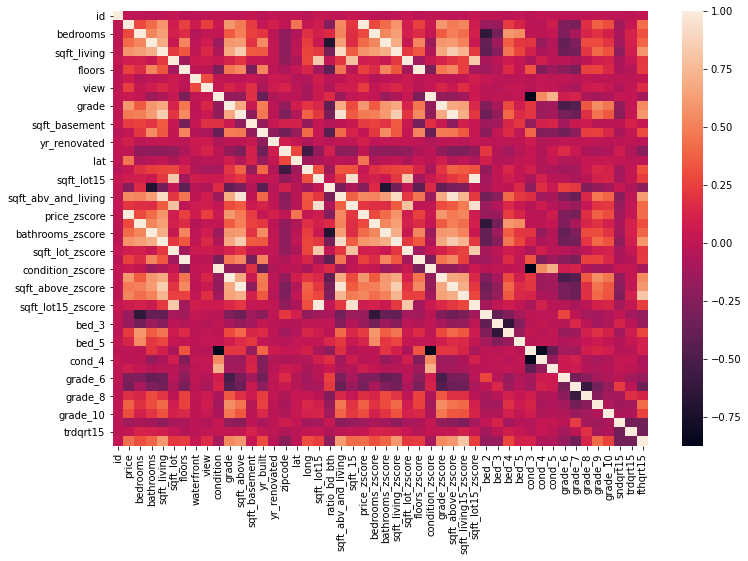

In [18]:
fig_dims = (12, 8)
fig, ax = plt.subplots(figsize = fig_dims)
sns.heatmap(kc_data.corr(), ax=ax)
plt.show()

In [19]:
# Fitting the actual model

#['long*lat'] = kc_data['long']

x_cols = ['lat', 'long', 'zipcode']

kc_data2 = kc_data[['price', 'lat', 'long', 'zipcode']].copy()

predictors = '+'.join(x_cols)
formula = outcome + '~' + predictors
model = ols(formula=formula, data=kc_data2).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.221
Model:                            OLS   Adj. R-squared:                  0.221
Method:                 Least Squares   F-statistic:                     1783.
Date:                Wed, 02 Dec 2020   Prob (F-statistic):               0.00
Time:                        08:23:52   Log-Likelihood:            -2.5537e+05
No. Observations:               18890   AIC:                         5.107e+05
Df Residuals:                   18886   BIC:                         5.108e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    1.53e+07   2.42e+06      6.326      0.000    1.06e+07       2e+07
lat         7.061e+05   9687.901     72.882      0.000    6.87e+05    7.25e+05
long        4.749e+04   1.14e+04      4.160      0.000    2.51e+04    6.99e+04
zipcode     -434.4491     30.518    -14.236      0.000    -494.266    -374.632
==============================================================================
Omnibus:                     2340.716   Durbin-Watson:                   1.985
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3470.369
Skew:                           0.919   Prob(JB):                         0.00
Kurtosis:                       4.015   Cond. No.                     1.81e+08
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.81e+08. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [20]:
kc_data = pd.get_dummies(kc_data['zipcode'], prefix='zip', drop_first=True)

In [23]:
kc_data[kc_data['zipcode'] == 98102]

KeyError: 'zipcode'

In [ ]:

zip_98002 = kc_data.loc[kc_data['zip_98002.0'] == True].copy()
zip_98002  = zip_98002.merge(kc_data)

In [ ]:
# Fitting the actual model

#['long*lat'] = kc_data['long']

x_cols = ['lat', 'long', 'zipcode']

kc_data2 = zip_98002[['price', 'lat', 'long', 'zipcode']].copy()

predictors = '+'.join(x_cols)
formula = outcome + '~' + predictors
model = ols(formula=formula, data=kc_data2).fit()
model.summary()

In [ ]:
zip_98002